Import all necessary packages

In [26]:
import numpy as np ### numpy for array modifications
import pandas as pd ### pandas for dataframe handling
import seaborn as sns ### seaborn for data vis
from sklearn.linear_model import LinearRegression ### regression model from skleanr

from nba_api.stats.static import players ### all nba players -- not box score data, just player IDs
from nba_api.stats.static import teams ### all nba teams -- not box score data, just teans IDs
from nba_api.stats.endpoints import playergamelog ### player game stats
from nba_api.stats.endpoints import leaguegamefinder ### team game stats
from nba_api.stats.endpoints import teamgamelog ### team game logs

Creating a dictionary of all players all time.

In [27]:
player_dict = players.get_players() 

Creating a dictionary of all active players.

In [28]:
active_player_dict = [player for player in player_dict if player['is_active'] ==  True]

A function that finds the player id given the player name.

The parameter player_name is a string.

The output is the corresponding players's id as an int.

In [29]:
def player_id_finder(player_name):
    for player in active_player_dict:
        if player['full_name'] == player_name:
            return player['id']

The below creates a dictionary, pairing each team's abbreviation with the full team name.

In [30]:
x = ['ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']
y = ['Atlanta Hawks','Boston Celtics','Brooklyn Nets','Charlotte Hornets','Chicago Bulls','Cleveland Cavaliers','Dallas Mavericks','Denver Nuggets','Detroit Pistons','Golden State Warriors','Houston Rockets','Indiana Pacers','Los Angeles Clippers','Los Angeles Lakers','Memphis Grizzlies','Miami Heat','Milwaukee Bucks','Minnesota Timberwolves','New Orleans Pelicans','New York Knicks','Oklahoma City Thunder','Orlando Magic','Philadelphia 76ers','Phoenix Suns','Portland Trail Blazers','Sacramento Kings','San Antonio Spurs','Toronto Raptors', 'Utah Jazz', 'Washington Wizards']
team_name_dict = {k:v for k, v in zip(x,y)}

Creating a dictionary of all teams.

In [31]:
team_dict = teams.get_teams()

A function that finds the team id given the team name.

The parameter team_name is a string.

The output is the corresponding team's id as an int.

In [32]:
def team_id_finder(team_name):
    for team in team_dict:
        if team['full_name'] == team_name:
            return team['id']

A function that saves team data by season as a csv file.

The parameters
- seasons_list: list (of seasons in format [20xx-xx, 20xx-xx, ...]
- season_type: str ('Regular Season', 'Playoffs')

The Output
- saves the dataframe created from the API call as a csv file (no output)

In [33]:
def save_team_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'teams.csv'
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

A function that saves player data by season as a csv file.

The parameters
- seasons_list: list (of seasons in format [20xx-xx, 20xx-xx, ...]
- season_type: str ('Regular Season', 'Playoffs')

The Output
- saves the dataframe created from the API call as a csv file (no output)

In [34]:
def save_player_datasets(seasons_list, season_type):
    for season in seasons_list:
        print('loading season', season)
        df = leaguegamefinder.LeagueGameFinder(player_or_team_abbreviation='P' ,season_nullable = season, league_id_nullable = '00', season_type_nullable = season_type).get_data_frames()[0]
        filename = str(season) + 'players.csv'
        df.to_csv(filename, index=False)
        print('Successully saved', filename)

In [35]:
seasons_list = ['2018-19', '2019-20', '2020-21', '2021-22', '2022-23']

#save_team_datasets(seasons_list, 'Regular Season')

In [36]:
#save_player_datasets(seasons_list, 'Regular Season')

In [37]:
players_2023 = pd.read_csv('2022-23players.csv')

In [38]:
teams_2023 = pd.read_csv('2022-23teams.csv')

In [49]:
def player_off_trends(player_name, players_df, teams_df):
    #retrieve the players stats from the player_df
    player_df = players_df[players_df['PLAYER_NAME'] == player_name]

    #retrieve the ids of the games the player played in
    player_game_ids = list(player_df['GAME_ID'])

    #retreieve the stats from the teams in all the games the player played in
    player_games = teams_df[teams_df['GAME_ID'].isin(player_game_ids)]

    #create a set of player team ids --> incase they are traded midseason and play for different teams
    player_team_id_set = set(list(player_df['TEAM_ID']))
    
    #calculate the opposing team's defensive rating (opponent's points)/(possesions) * 100 where possesions = (FGA - OREB + TOV + (FTA * 0.4))
    team_pts = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['PTS'])
    team_fga = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['FGA'])
    team_oreb = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['OREB'])
    team_tov = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['TOV'])
    team_fta = np.array(player_games.loc[player_games['TEAM_ID'].isin(player_team_id_set)]['FTA'])

    opp_def_ratings = (team_pts)/(team_fga - team_oreb + team_tov + (team_fta * 0.4)) * 100

    #create a dictionary mapping the game ids to the def ratings.
    id_def_rating_dict = {k:v for k,v in zip(player_game_ids, opp_def_ratings)}

    #map the opponent defensive rating onto player_df
    player_df['opp_def_rating'] = player_df['GAME_ID'].map(id_def_rating_dict)

    #plot regression lines and find basic stats.
    x = np.array(player_df['opp_def_rating']).reshape(-1, 1)
    
    sns.lmplot(data=player_df, x='opp_def_rating', y='PTS')
    y1 = list(player_df['PTS'])
    pts_model = LinearRegression().fit(x, y1)
    print('R-squared for pts:', pts_model.score(x,y1))
    
    sns.lmplot(data=player_df, x='opp_def_rating', y='REB')
    y2 = list(player_df['REB'])
    pts_model = LinearRegression().fit(x, y2)
    print('R-squared for reb:', pts_model.score(x,y2))
          
    sns.lmplot(data=player_df, x='opp_def_rating', y='AST')
    y3 = list(player_df['AST'])
    pts_model = LinearRegression().fit(x, y3)
    print('R-squared for ast:', pts_model.score(x,y3))

/var/folders/yr/8r7k02194lg4gt6j9mv7q7340000gn/T/ipykernel_66891/1064568270.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['opp_def_rating'] = player_df['GAME_ID'].map(id_def_rating_dict)


R-squared for pts: 0.0784014047221121
R-squared for reb: 0.03618451580932014
R-squared for ast: 0.08681451633626303


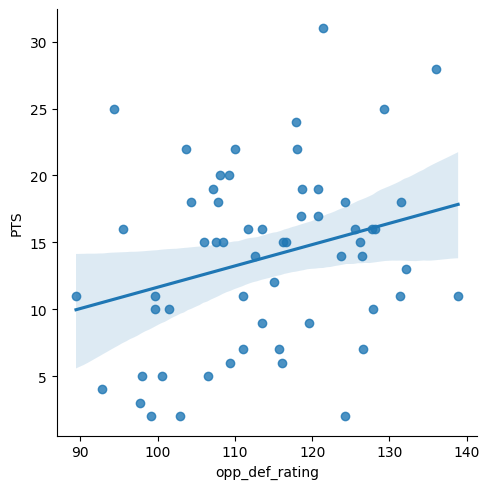

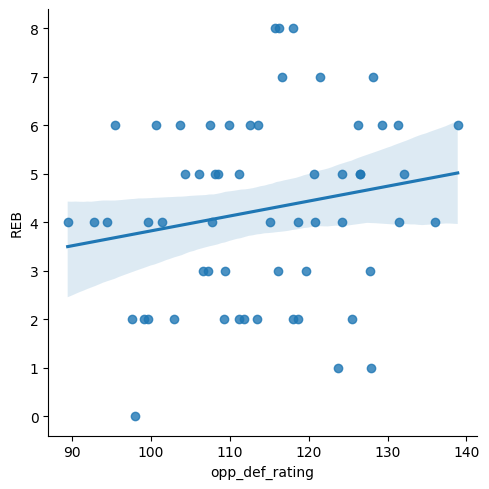

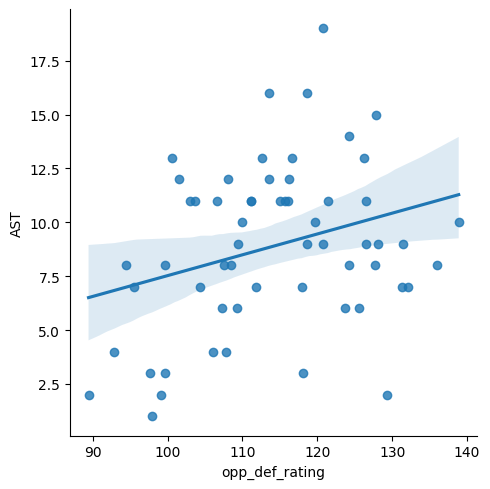

In [52]:
player_off_trends('Chris Paul', players_2023, teams_2023)